In [4]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w_ext_o_dummy/"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w_ext_o_dummy/",per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.4

In [6]:
 #Load inputs and outputs in dataframes
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)

# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, executions, te_s, val_s)

#Create dataloaders
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, executions)

#Create TensorDatasets
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float(), d_ft_inter['train'])
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float(), d_ft_inter['val'].float())

input_f_sc01_Network_Existing_Generation_Full_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
86
input_f_sc01_N

In [7]:
executions = list(dfs_in.keys())
tr_exs = list(ts_in["train"].keys())
te_exs = list(ts_in["test"].keys())
val_exs = list(ts_in["val"].keys())

In [8]:
folder_trained = "RTS24_AC_12w_dummy_All_Exec_dummy_t0.3_v0.4_PF_sa_0_40"
folder_trained = "RTS24_AC_12w_dummy_0.3_v0.4_PF_sa_rand_0_40"
folder_trained = "RTS24_AC_12w_dummy_0.3_v0.4_PF_LB_0_40"
mt = "min_val"
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

dor = 0
lr = 0.000625
nb_e = 64
nb_hidden = (3,1)
relu_out = True
np = 0
bs = 64
MAE=True
alpha=0

print(nb_hidden)
models = dict()
for nb_hidden in [(3,1)]: 
    key = nb_hidden
    #m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
    #m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro"
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"
    
    path = f"ResultsClusterRuns/trained_models/{folder_trained}/{mt}/model_{m_name}.pth"
    path = f"trained_models/{folder_trained}/{mt}/model_{m_name}.pth"

    models[key] = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1], dropout_ratio= dor,relu_out =relu_out,inter=True,inter_size=inter_size)
    models[key].load_state_dict(torch.load(path))
    models[key].eval()



(3, 1)
[172, 258, 62, 38, 19]


FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/RTS24_AC_12w_dummy_0.3_v0.4_PF_LB_0_40/min_val/model_OE_(3, 1)h_64e_0.000625lr_0dor_0np_Truero_64bs_0ill_TrueMAE.pth'

In [13]:
#Check an execution part of training set

#First, select an execution
execution = tr_exs[0]
#Load the input and output data for this execution
ex_in = torch.nan_to_num(ts_in["train"][execution]/maxs["in"])
ex_out = ts_out["train"][execution]
ex_inter = ts_inter["train"][execution]

loss_fn_1 = torch.nn.L1Loss()
loss_fn_2 = torch.nn.MSELoss()

#Make model predictions based on input
predictions = dict()

for k in models:
    print(k)
    m = models[k]
    predictions[k] = m(ex_in.float())

(3, 1)


In [14]:
(loss_fn_2(predictions[k][0].squeeze(),ex_out))

tensor(7.0553e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)

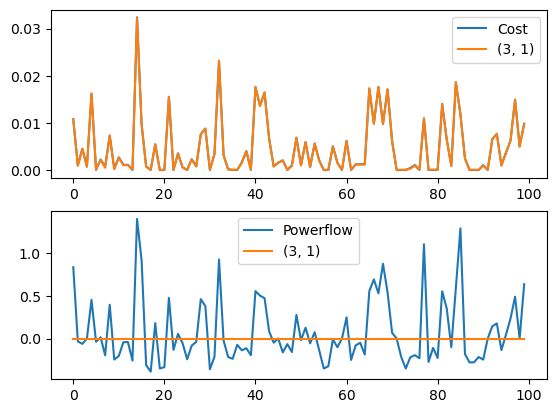

In [15]:
s = 0
e = s+100

index_inter = 2
fig,axs = plt.subplots(2,1)
for k in predictions:
    axs[0].plot(ex_out[s:e],label = "Cost")
    axs[0].plot(predictions[k][0].detach()[s:e],label = f"{k}")
    axs[1].plot(ex_inter[s:e,index_inter],label = "Powerflow")
    axs[1].plot(predictions[k][1][s:e,index_inter].detach(),label = f"{k}")
axs[0].legend()
axs[1].legend()



Train example
Train example


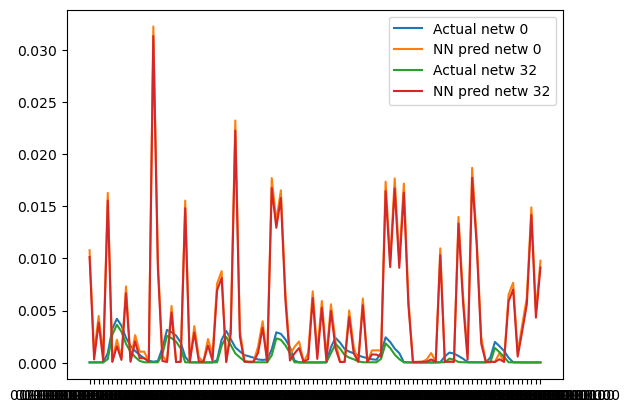

In [16]:
#Compare the results of different executions 
i,j = 0,32
s = 0
e = s+100

for k in [i,j]:
    name = executions[k]
    if name in ts_in["train"].keys():
        ex_in = torch.nan_to_num(ts_in["train"][name]/maxs["in"])
        print("Train example")
    elif name in ts_in["test"].keys(): 
        ex_in = torch.nan_to_num(ts_in["test"][name]/maxs["in"])
        print("Test example")
    elif name in ts_in["val"].keys():
        print("Validation example")
        ex_in = torch.nan_to_num(ts_in["val"][name]/maxs["in"])

        
    predictions[k] = m(ex_in.float())[0]

    plt.plot(dfs_out[executions[k]].sum(axis=1)[s:e],label = f"Actual netw {k} ")
    plt.plot(predictions[k].detach()[s:e],label = f"NN pred netw {k}")

plt.legend()

In [8]:
#Check an execution part of training set

#First, select an execution
execution = tr_exs[0]
#Load the input and output data for this execution
ex_in = torch.nan_to_num(ts_in["train"][execution]/maxs)
ex_out = ts_out["train"][execution]
loss_fn_1 = torch.nn.L1Loss()
loss_fn_2 = torch.nn.MSELoss()


#Make model predictions based on input
predictions = dict()

for k in models:
    print(k)
    m = models[k]
    predictions[k] = m(ex_in.float())

NameError: name 'maxs' is not defined